In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from datetime import datetime, timedelta
import folium
from folium import Popup
from folium.plugins import HeatMap
import seaborn as sns

In [2]:
# Load the datasets from JSON files
user_data = pd.read_json('database_generator/user_data.json')
landlord_data = pd.read_json('database_generator/landlord_data.json')
history_data = pd.read_json('database_generator/history_data.json')
private_parking_data = pd.read_json('database_generator/private_parking.json')
public_parking_data = pd.read_json('database_generator/public_parking.json')

# Show the first few rows to verify the data
print(user_data.head())
print(landlord_data.head())
print(history_data.head())
print(private_parking_data.head())
print(public_parking_data.head())


    user_id              name       username  password license_plate_number  \
0  UID80994     Mia Schneider  mschneider372  PgGJ1zWU           FR BT 3750   
1  UID72463     Sophia Wagner     swagner382  9IbfpS2W           FR XM 9798   
2  UID78439  Moritz Schneider  mschneider942  IcrXM52q           FR IC 9583   
3  UID99228      Mia Hoffmann   mhoffmann645  2K6P5TM4           FR TZ 3823   
4  UID25562       Anna Müller     amüller269  WiY95whH           FR IZ 2666   

   credits                      email     phone_number  \
0   164.38     mschneider372@mail.com  +49 153 5695266   
1   162.00     swagner382@example.com  +49 157 1251081   
2    46.22  mschneider942@webmail.org  +49 155 3554367   
3   109.71   mhoffmann645@example.com  +49 155 1642871   
4   448.06     amüller269@example.com  +49 159 9889936   

                    address  
0  21 Kirchplatz, Offenburg  
1         52 Hauptstr., Ulm  
2   48 Gartenweg, Stuttgart  
3   90 Gartenweg, Karlsruhe  
4  71 Bahnhofstr., Konstan

In [3]:
# Check general information for each dataframe
print(user_data.info())
print(landlord_data.info())
print(history_data.info())
print(private_parking_data.info())
print(public_parking_data.info())

# Check basic statistics for numerical columns
print(user_data.describe())
print(landlord_data.describe())
print(history_data.describe())
print(private_parking_data.describe())
print(public_parking_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               80000 non-null  object 
 1   name                  80000 non-null  object 
 2   username              80000 non-null  object 
 3   password              80000 non-null  object 
 4   license_plate_number  80000 non-null  object 
 5   credits               80000 non-null  float64
 6   email                 80000 non-null  object 
 7   phone_number          80000 non-null  object 
 8   address               80000 non-null  object 
dtypes: float64(1), object(8)
memory usage: 5.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   landlord_id   5000 non-null   object
 1   name          5000 non-null   object


In [4]:
# Check for missing values
print("MISSING VALUES:")
print(user_data.isnull().sum())
print(landlord_data.isnull().sum())
print(history_data.isnull().sum())
print(private_parking_data.isnull().sum())
print(public_parking_data.isnull().sum())

# Check for duplicates
print("DUPLICATE VALUES:")
print(user_data.duplicated().sum())
print(landlord_data.duplicated().sum())
print(history_data.duplicated().sum())

def exclude_array_columns(df):
    # Check if the column contains array-like objects
    non_array_columns = [col for col in df.columns if not isinstance(df[col].iloc[0], (list, pd.Series))]
    return df[non_array_columns]

# Apply to both private and public parking data
private_parking_non_array = exclude_array_columns(private_parking_data)
public_parking_non_array = exclude_array_columns(public_parking_data)

# Now, check for duplicates excluding array columns
print(private_parking_non_array.duplicated().sum())  
print(public_parking_non_array.duplicated().sum())

MISSING VALUES:
user_id                 0
name                    0
username                0
password                0
license_plate_number    0
credits                 0
email                   0
phone_number            0
address                 0
dtype: int64
landlord_id     0
name            0
username        0
password        0
phone_number    0
availability    0
dtype: int64
history_id           0
rating               0
review_text          0
user_id              0
parking_id           0
parking_latitude     0
parking_longitude    0
booking_latitude     0
booking_longitude    0
distance             0
datetime             0
dtype: int64
private_id         0
name               0
address            0
latitude           0
longitude          0
price_per_hour     0
capacity           0
available_space    0
special_access     0
landlord_id        0
opening_time       0
city               0
note_area          0
key_access_info    0
dtype: int64
public_id          0
name               0
a

In [5]:
# Merge the history data with user data to analyze booking behavior
user_history = pd.merge(history_data, user_data, on='user_id')

# Count how many times each user has booked a parking space
user_booking_counts = user_history.groupby('user_id').size().reset_index(name='booking_count')
print(user_booking_counts.head())

# Explore the average rating per user
avg_ratings_per_user = user_history.groupby('user_id')['rating'].mean().reset_index(name='average_rating')
print(avg_ratings_per_user.head())


    user_id  booking_count
0  UID10000              1
1  UID10001              4
2  UID10003              1
3  UID10005              1
4  UID10007              1
    user_id  average_rating
0  UID10000            5.00
1  UID10001            3.75
2  UID10003            2.00
3  UID10005            3.00
4  UID10007            5.00


In [6]:
# Check the number of private and public parking spaces
private_parking_count = private_parking_data.shape[0]
public_parking_count = public_parking_data.shape[0]
print(f"Private parking spaces: {private_parking_count}")
print(f"Public parking spaces: {public_parking_count}")

# Explore the total capacity of private and public parking spaces
total_private_capacity = private_parking_data['capacity'].sum()
total_public_capacity = public_parking_data['capacity'].sum()
print(f"Total private parking capacity: {total_private_capacity}")
print(f"Total public parking capacity: {total_public_capacity}")

# Explore the total available space of private and public parking spaces
total_private_available_space = private_parking_data['available_space'].sum()
total_public_available_space = public_parking_data['available_space'].sum()
print(f"Total private parking available_space: {total_private_available_space}")
print(f"Total public parking available_space: {total_public_available_space}")


Private parking spaces: 10000
Public parking spaces: 2490
Total private parking capacity: 75127
Total public parking capacity: 214797
Total private parking available_space: 30126
Total public parking available_space: 103548


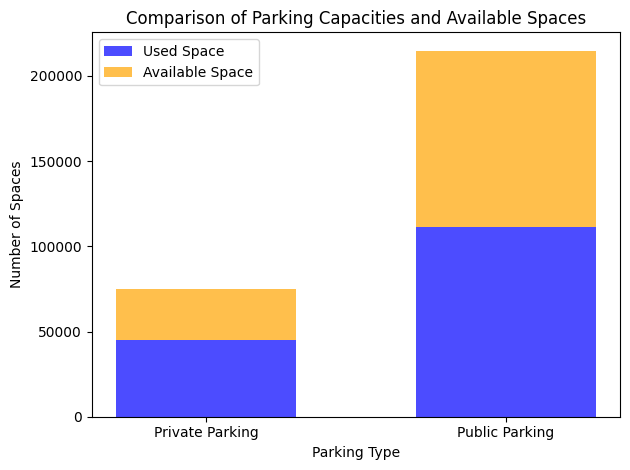

In [7]:
# Labels and values
categories = ['Private Parking', 'Public Parking']
capacity = [total_private_capacity, total_public_capacity]
available_space = [total_private_available_space, total_public_available_space]
used_space = [c - a for c, a in zip(capacity, available_space)]  # Calculate used space

# Bar positions
x = np.arange(len(categories))

# Plot stacked bars
plt.bar(x, used_space, width=0.6, label='Used Space', color='blue', alpha=0.7)
plt.bar(x, available_space, width=0.6, label='Available Space', color='orange', alpha=0.7, bottom=used_space)

# Add labels and title
plt.xlabel('Parking Type')
plt.ylabel('Number of Spaces')
plt.title('Comparison of Parking Capacities and Available Spaces')
plt.xticks(x, categories)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

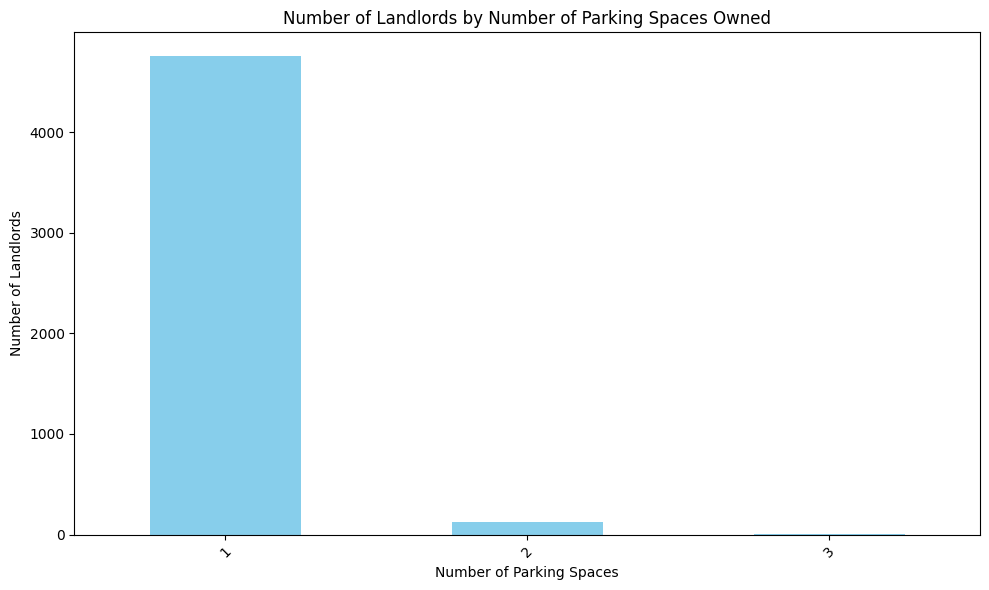

In [8]:
# Group by the number of parking spaces per landlord and count the number of landlords
landlords_by_parking_spaces = landlord_data.groupby('landlord_id').size().value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
landlords_by_parking_spaces.sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Landlords by Number of Parking Spaces Owned')
plt.xlabel('Number of Parking Spaces')
plt.ylabel('Number of Landlords')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


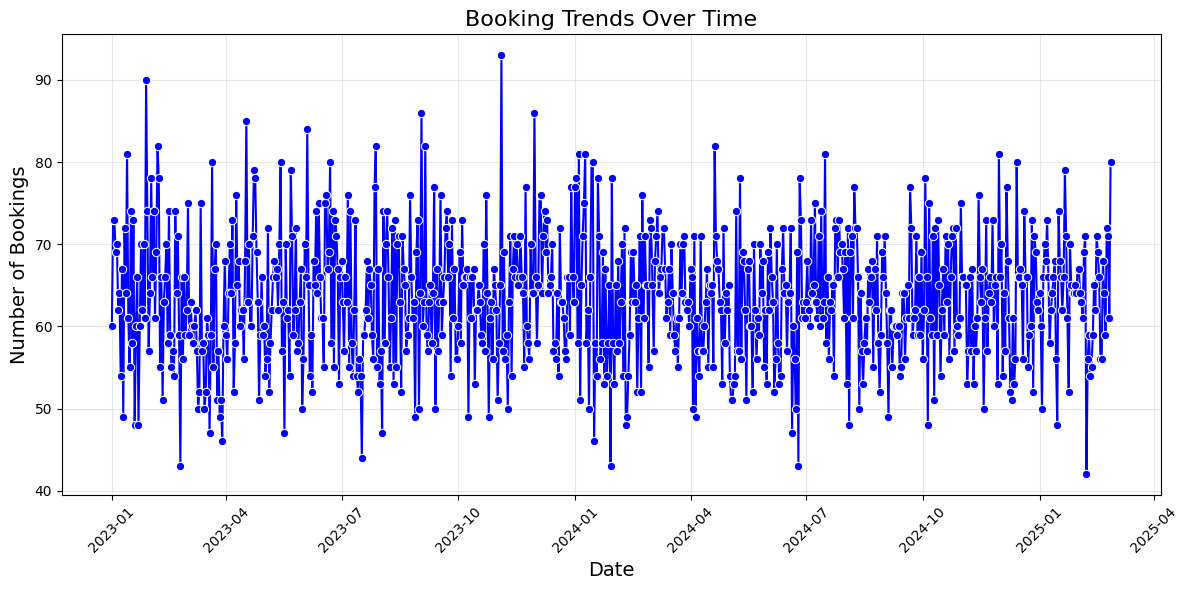

In [9]:
daily_bookings = history_data.groupby(history_data['datetime'].dt.date).size()

# Convert the result to a DataFrame for better manipulation
daily_bookings = daily_bookings.reset_index(name='num_bookings')
daily_bookings.rename(columns={'datetime': 'date'}, inplace=True)

# Plotting the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_bookings, x='date', y='num_bookings', marker='o', color='b')

# Customize the plot
plt.title('Booking Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Bookings', fontsize=14)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [10]:
# Merge the private parking data with landlord data
private_parking_landlord = pd.merge(private_parking_data, landlord_data, on='landlord_id')

# Count the number of parking spaces each landlord manages
landlord_parking_count = private_parking_landlord.groupby('landlord_id')['private_id'].count().reset_index(name='parking_count')
print(landlord_parking_count.head())

# Count the number of private parking spaces per landlord
landlord_parking_capacity = private_parking_landlord.groupby('landlord_id')['capacity'].sum().reset_index(name='total_capacity')
print(landlord_parking_capacity.head())


  landlord_id  parking_count
0    LID10025              1
1    LID10032              1
2    LID10047              1
3    LID10055              5
4    LID10068              1
  landlord_id  total_capacity
0    LID10025              10
1    LID10032               6
2    LID10047               9
3    LID10055              42
4    LID10068              10


In [11]:
# Make sure datetime columns are in datetime format
history_data['datetime'] = pd.to_datetime(history_data['datetime'])

# If any NaN values are present, handle them (drop or fill)
history_data = history_data.dropna(subset=['datetime'])

# Get today's date and the date 30 days ago
time_range = datetime.now() - timedelta(days=1)

# Filter the history_data to include only the rows from the last 30 days
history_data_recent = history_data[history_data['datetime'] >= time_range]

# Function to calculate distance
def calculate_distance(row):
    try:
        parking_location = (row['parking_latitude'], row['parking_longitude'])
        booking_location = (row['booking_latitude'], row['booking_longitude'])
        return geodesic(parking_location, booking_location).km
    except Exception as e:
        print(f"Error calculating distance for row: {row}, Error: {e}")
        return np.nan  # Return NaN for problematic rows

# Filter out rows where any required latitude/longitude values are missing
history_data_recent = history_data.dropna(subset=['parking_latitude', 'parking_longitude', 'booking_latitude', 'booking_longitude'])

# Recalculate distance
history_data_recent['calculated_distance'] = history_data_recent.apply(calculate_distance, axis=1)

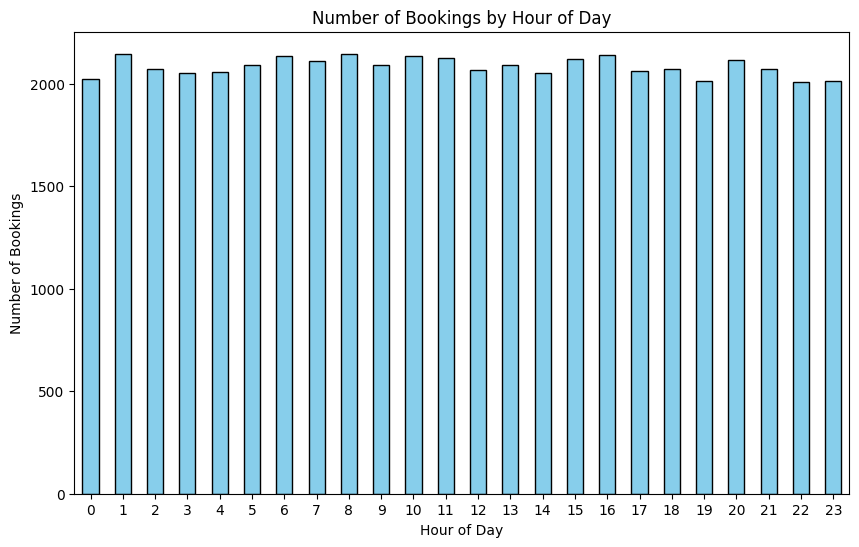

In [12]:
# Convert datetime to pandas datetime format if it's not already
history_data['datetime'] = pd.to_datetime(history_data['datetime'])

# Extract hour of booking
history_data['hour_of_day'] = history_data['datetime'].dt.hour

# Group by hour of the day and count bookings
booking_by_hour = history_data.groupby('hour_of_day').size()

# Plot the booking count by hour
plt.figure(figsize=(10, 6))
booking_by_hour.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Bookings by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=0)
plt.show()


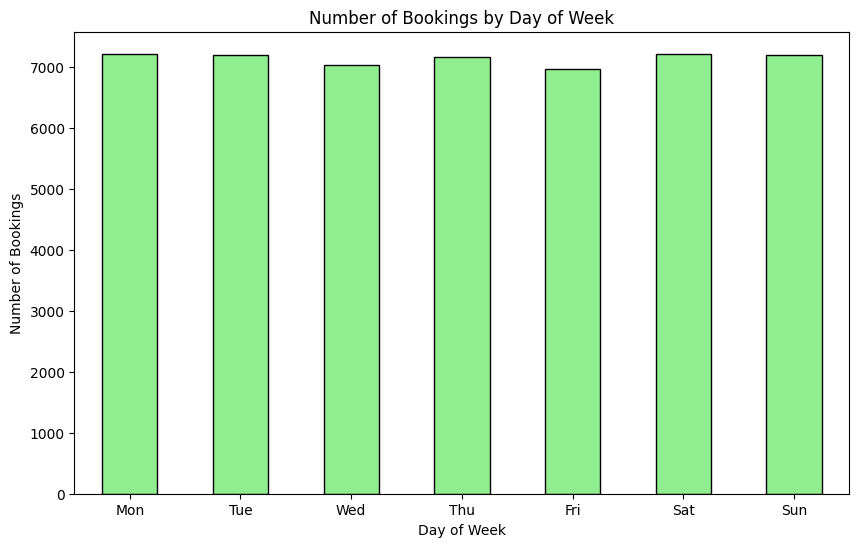

In [13]:
# Extract the day of the week from datetime (0 = Monday, 6 = Sunday)
history_data['day_of_week'] = history_data['datetime'].dt.dayofweek

# Group by day of the week and count bookings
booking_by_day = history_data.groupby('day_of_week').size()

# Plot the booking count by day of the week
plt.figure(figsize=(10, 6))
booking_by_day.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Number of Bookings by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Bookings')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


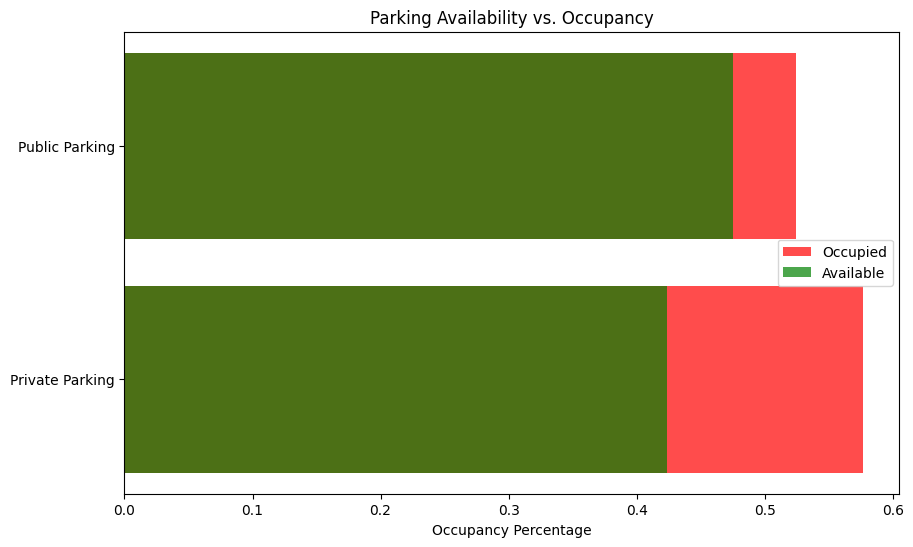

In [14]:
# Clean up missing values before occupancy calculation
private_parking_data = private_parking_data.dropna(subset=['available_space', 'capacity'])
public_parking_data = public_parking_data.dropna(subset=['available_space', 'capacity'])

# Calculate occupancy for private and public parking
private_parking_data['occupancy'] = 1 - (private_parking_data['available_space'] / private_parking_data['capacity'])
public_parking_data['occupancy'] = 1 - (public_parking_data['available_space'] / public_parking_data['capacity'])

# Calculate occupancy percentage for private and public parking
private_parking_data['occupancy'] = 1 - (private_parking_data['available_space'] / private_parking_data['capacity'])
public_parking_data['occupancy'] = 1 - (public_parking_data['available_space'] / public_parking_data['capacity'])

# Plot stacked bar chart for occupancy
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(['Private Parking', 'Public Parking'], 
        [private_parking_data['occupancy'].mean(), public_parking_data['occupancy'].mean()],
        color='red', alpha=0.7, label='Occupied')

ax.barh(['Private Parking', 'Public Parking'], 
        [1 - private_parking_data['occupancy'].mean(), 1 - public_parking_data['occupancy'].mean()],
        color='green', alpha=0.7, label='Available')

ax.set_xlabel('Occupancy Percentage')
ax.set_title('Parking Availability vs. Occupancy')
ax.legend()
plt.show()


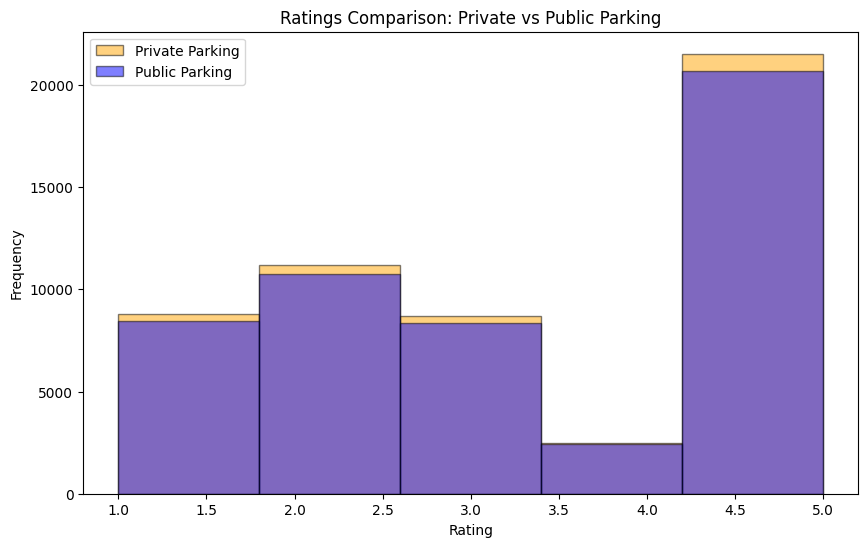

In [15]:
# Merge the history data with private and public parking data
history_private_parking = pd.merge(history_data, private_parking_data, left_on='parking_id', right_on='private_id', how='left')
history_public_parking = pd.merge(history_data, public_parking_data, left_on='parking_id', right_on='public_id', how='left')

# Plot the ratings comparison for private vs public parking
plt.figure(figsize=(10, 6))

# Plot ratings for private parking
plt.hist(history_private_parking['rating'], bins=5, alpha=0.5, label='Private Parking', color='orange', edgecolor='black')

# Plot ratings for public parking
plt.hist(history_public_parking['rating'], bins=5, alpha=0.5, label='Public Parking', color='blue', edgecolor='black')

plt.title('Ratings Comparison: Private vs Public Parking')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.show()
